### <font color='tomato'><font color="#CC3D3D"><p>
# Baseline Code (v1.0)

- **문제**   
*"각 패널에게 어떤 온라인 설문조사를 요청해야 응답할까?"*    
**KML Challenge 2023F**에서는 이 문제를 가장 잘 해결할 수 있는 예측 모델을 개발하는 것이 목적
- **평가척도**   
정확도(Accuracy)
- **데이터**   
   - train.csv(학습데이터), test.csv(평가테이터)
   - 각 데이터 포인트는 패널 정보, 설문정보, 응답여부(STATUS)로 구성

### Imports

In [1]:
import os
import random
import pickle
import gc
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, cross_val_predict
from sklearn.metrics import roc_auc_score, mean_squared_error, make_scorer, accuracy_score
from sklearn import set_config
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, StackingRegressor, GradientBoostingRegressor,VotingClassifier, VotingRegressor, StackingRegressor, HistGradientBoostingRegressor, GradientBoostingClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.svm import SVC, SVR
from xgboost import XGBRegressor,XGBClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
import lightgbm as lgb
import category_encoders as ce
import re
import optuna
import math

### Data Loading

In [2]:
# train = pd.read_csv('/kaggle/input/kml-challenge-2023f/train.csv', encoding='cp949')
# test = pd.read_csv('/kaggle/input/kml-challenge-2023f/test.csv', encoding='cp949')

In [3]:
train = pd.read_csv('train.csv', encoding='cp949')
test = pd.read_csv('test.csv', encoding='cp949')

### 데이터 설명
- **패널(Panel) 데이터**
  - userID: 패널 ID
  - BIRTH: 생일(연도)
  - GENDER: 1(남자) 2(여자)
  - REGION: 거주지역
  - TYPE: 패널 구분
  - SQ1 ~ DQ7: 패널 가입 시 설문한 데이터로 각 필드에 대해서는 [상세설명](https://docs.google.com/spreadsheets/d/1pY6MYTSkyHrGLmMTU8tX_xlD8fPut6Ob/edit?usp=sharing&ouid=107121563618260277687&rtpof=true&sd=true) 참조
- **설문(Survey) 데이터**
  - surveyID: 설문 ID
  - TITLE: 설문 제목
  - IR: 난이도(응답가능성, 100이 최고)
  - LOI: 설문하는데 걸리는 시간 (분단위)
  - CATEGORIES: 설문 분류
  - CPI: 패널 응답 리워드 포인트(1P~)
- **응답(Response) 데이터**
  - STATUS: 응답여부 (Target)
  - (test 데이터의) ID: submission을 식별하기 위한 ID로 사용

### Data Preprocessing

In [4]:
# 결측값 비율이 30% 이하인 column만 사용
features = []
for f in train.columns:
    if train[f].isnull().sum()/train.shape[0] <= 0.3:
        print(f, '\t', train[f].nunique(), '\t', train[f].isnull().sum()/train.shape[0])
        features.append(f)

userID 	 15155 	 0.0
surveyID 	 1293 	 0.0
BIRTH 	 76 	 0.0
GENDER 	 2 	 0.0
REGION 	 17 	 0.0
TYPE 	 3 	 0.0
SQ1 	 2 	 0.0009770785964481042
SQ2 	 82 	 0.0014293615190806859
SQ3 	 47 	 0.09023044306520002
SQ4 	 52 	 0.09058931973207153
SQ5 	 273 	 0.14450930989983407
SQ6 	 30 	 0.14490751551649972
SQ7 	 1234 	 0.1802556381736619
SQ8 	 1774 	 0.1831610643397038
A1 	 2768 	 0.2083279051189086
B1 	 131 	 0.21447796964296686
B2 	 120 	 0.2426792847047256
B3 	 110 	 0.24790757696798377
B4 	 715 	 0.2602888219750507
B5 	 669 	 0.26743317151109197
TITLE 	 1286 	 0.0
IR 	 42 	 0.0
LOI 	 26 	 0.0
CPI 	 43 	 0.0
STATUS 	 2 	 0.0


In [5]:
# handle_profile은 숫자가 문자와 숫자형태를 둘다 표시되어 이에 대한 수정코드 구현
# 0은 결측값, 98은 중복값을 포함한 이상한 숫자

In [6]:

def handle_profile(x):
    if pd.isna(x):
        return 0
    elif x in range(1,7):
        return int(x)
    elif x == 97:
        return int(x)
    elif x in ['1', '2', '3', '4', '5', '6', '97']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,', '97,']:
        return int(x[0])
    elif str(x).startswith('97,'):
        return 97
    else:
        return 98
train.SQ4 = train.SQ4.apply(handle_profile)
test.SQ4 = test.SQ4.apply(handle_profile)

In [7]:
def handle_profile(x):
    if pd.isna(x):
        return 0
    elif x in range(1,5):
        return int(x)
    elif x in ['1', '2', '3', '4']:
        return int(x)
    elif x in ['1.0', '2.0', '3.0', '4.0']:
        return int(x[0])
    else:
        return 98
train.SQ5 = train.SQ5.apply(handle_profile)
test.SQ5 = test.SQ5.apply(handle_profile)

In [8]:
def handle_profile(x):
    if pd.isna(x):
        return 0
    elif x in range(1,3):
        return int(x)
    elif x == 97:
        return int(x)
    elif x in ['1', '2','97']:
        return int(x)
    elif x in ['1,', '2,','97,']:
        return int(x[0])
    elif str(x).startswith('97,'):
        return 97
    else:
        return 98
train.SQ6 = train.SQ6.apply(handle_profile)
test.SQ6 = test.SQ6.apply(handle_profile)

In [9]:
def handle_profile(x):
    if pd.isna(x):
        return 0
    elif x in range(1,17):
        return int(x)
    elif x == 99:
        return int(x)
    elif x in ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','99']:
        return int(x)
    elif x in ['1.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0','10.0','11.0','12.0','13.0','14.0','15.0','16.0','99.0']:
        return int(x.split('.')[0])
    elif x in ['1,','2,','3,','4,','5,','6,','7,','8,','9,','10,','11,','12,','13,','14,','15,','16,','99,']:
        return int(x.split(',')[0])
    else:
        return 98

train.SQ7 = train.SQ7.apply(handle_profile)
test.SQ7 = test.SQ7.apply(handle_profile)

In [10]:
def handle_profile(x):
    if pd.isna(x):
        return 0
    elif x in range(1,6):
        return int(x)
    elif x in ['1', '2', '3', '4', '5']:
        return int(x)
    elif x in ['1.0','2.0','3.0','4.0','5.0']:
        return int(x[0])
    else:
        return 98

train.SQ8 = train.SQ8.apply(handle_profile)
test.SQ8 = test.SQ8.apply(handle_profile)

In [11]:
def handle_profile(x):
    if pd.isna(x):
        return 0
    elif x in range(1,23):
        return int(x)
    elif x == 99:
        return int(x)
    elif x in ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17', '18', '19', '20', '21', '22', '99']:
        return int(x)
    else:
        return 98
train.A1 = train.A1.apply(handle_profile)
test.A1 = test.A1.apply(handle_profile)

In [12]:
def handle_profile(x):
    if pd.isna(x):
        return 0
    elif x in ['1',1, 1.0]:
        return 2
    elif x in ['2', '3',2,3,2.0,3.0]:
        return 3
    elif x in ['4', '5', '6', '7',4,5,6,7,4.0,5.0,6.0,7.0]:
        return 4
    elif x in ['8', 8 ,8.0]:
        return 5
    else:
        return 99
train.B1 = train.B1.apply(handle_profile)
test.B1 = test.B1.apply(handle_profile)

In [13]:
def handle_profile(x):
    if pd.isna(x):
        return 0
    elif x in ['1', '2', '3', '4', '5', '6', '97', 1,2,3,4,5,6,97,1.0,2.0,3.0,4.0,5.0,6.0,97.0]:
        return int(x)
    else:
        return 98

train.B2 = train.B2.apply(handle_profile)
test.B2 = test.B2.apply(handle_profile)

In [14]:
def handle_profile(x):
    if pd.isna(x):
        return 0
    elif x in ['1', '2', '3']:
        return int(x)
    elif x in ['1,', '2,', '3,']:
        return int(x[0])
    elif x in ['99', '99,']:
        return 99
    else:
        return 4  # 기타 제조사

train.B3 = train.B3.apply(handle_profile)
test.B3 = test.B3.apply(handle_profile)

In [15]:
def handle_profile(x):
    if pd.isna(x):
        return 0
    elif x in range(1,9):
        return int(x)
    elif x == 97:
        return int(x)    
    elif x == 99:
        return int(x)
    elif x in ['1','2','3','4','5','6','7','8','97','99']:
        return int(x)
    else:
        return 98

train.B4 = train.B4.apply(handle_profile)
test.B4 = test.B4.apply(handle_profile)

In [16]:
def handle_profile(x):
    if pd.isna(x):
        return 0
    elif x in range(1,10):
        return int(x)
    elif x == 97:
        return int(x)    
    elif x == 99:
        return int(x)
    elif x in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '97', '99']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,', '7,', '8,', '9,', '10,', '97,', '99,']:
        return int(x[0])
    elif str(x).startswith('97,'):
        return 97
    else:
        return 98
train.B5 = train.B5.apply(handle_profile)
test.B5 = test.B5.apply(handle_profile)

In [17]:
word_counts = {}
def count_word(x): # 응답한 서베이 제목에서 한글 단어만 분리하고 빈도 계산
    if x['STATUS'] == 1:
        for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
            word_counts[w] = word_counts.get(w, 0) + 1
def score_word(x): # 빈도의 합으로 제목을 Encoding
    score = 0
    for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
        score += word_counts.get(w, 0)
    return score    
            
train.apply(count_word, axis=1)
train.TITLE = train.apply(score_word, axis=1)
test.TITLE = test.apply(score_word, axis=1)

In [18]:
# userID에 대한 응답률 feature 생성
res_freq = train.query('STATUS == 1').groupby('userID')['userID'].agg([('FREQ', np.size)]).reset_index()
send_freq = train.groupby('userID')['userID'].agg([('SEND', np.size)]).reset_index()
train = train.merge(res_freq, how='left').merge(send_freq, how='left')
#유저가 모든 설문응답을 안하면 총 status의 개수가 0이라 결측값 발생
train['RESRATE'] = train['FREQ'] / train['SEND']
#그 결측값을 0으로 대체
train['RESRATE'] = train['RESRATE'].fillna(0)

mean_resrate = train['RESRATE'].mean()

del train['FREQ'], train['SEND']


test = pd.merge(test, train.drop_duplicates(subset=['userID'])[['userID', 'RESRATE']], how='left')
# train 데이터에 없는 userID가 결측값으로 발생, 결측값을 평균값으로 대체(중앙값으로 해봤지만 결과값은 같음)
test['RESRATE'] = test['RESRATE'].fillna(mean_resrate)

In [19]:
# surveyID에 대한 응답률 feature 생성
res_freq = train.query('STATUS == 1').groupby('surveyID')['surveyID'].agg([('FREQ', np.size)]).reset_index()
send_freq = train.groupby('surveyID')['surveyID'].agg([('SEND', np.size)]).reset_index()
train = train.merge(res_freq, how='left').merge(send_freq, how='left')

train['RESRATE_s'] = train['FREQ'] / train['SEND']
train['RESRATE_s'] = train['RESRATE_s'].fillna(0)
mean_resrate_s = train['RESRATE_s'].mean()

del train['FREQ'], train['SEND']

test = pd.merge(test, train.drop_duplicates(subset=['surveyID'])[['surveyID', 'RESRATE_s']], how='left')

test['RESRATE_s'] = test['RESRATE_s'].fillna(mean_resrate_s)

In [20]:
#CPI에 대한 응답률 feature 생성
res_freq = train.query('STATUS == 1').groupby('CPI')['CPI'].agg([('FREQ', np.size)]).reset_index()
send_freq = train.groupby('CPI')['CPI'].agg([('SEND', np.size)]).reset_index()
train = train.merge(res_freq, how='left').merge(send_freq, how='left')

train['RESRATE_c'] = train['FREQ'] / train['SEND']
train['RESRATE_c'] = train['RESRATE_c'].fillna(0)
mean_resrate_c = train['RESRATE_c'].mean()

del train['FREQ'], train['SEND']

test = pd.merge(test, train.drop_duplicates(subset=['CPI'])[['CPI', 'RESRATE_c']], how='left')
test['RESRATE_c'] = test['RESRATE_c'].fillna(mean_resrate_c)

In [21]:
# IR별 status 응답여부의 비율
train_IR = ((train.groupby('IR')['STATUS'].sum())/(train.IR.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_IR'})
train = train.merge(train_IR,how='left')
test = test.merge(train_IR,how='left')
test.STATUS_ratio_IR=test.STATUS_ratio_IR.fillna(test.STATUS_ratio_IR.mean())

In [22]:
# LOI별 status 응답여부의 비율
train_LOI = ((train.groupby('LOI')['STATUS'].sum())/(train.LOI.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_LOI'})
train = train.merge(train_LOI,how='left')
test = test.merge(train_LOI,how='left')
test.STATUS_ratio_LOI=test.STATUS_ratio_LOI.fillna(test.STATUS_ratio_LOI.mean())

In [23]:
#CPI별 status 응답여부의 비율
train_CPI = ((train.groupby('CPI')['STATUS'].sum())/(train.CPI.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_CPI'})
train = train.merge(train_CPI,how='left')
test = test.merge(train_CPI,how='left')
test.STATUS_ratio_CPI=test.STATUS_ratio_CPI.fillna(test.STATUS_ratio_CPI.mean())

In [24]:
# type별 status의 평균
TYPE_mean = pd.DataFrame(train.groupby('TYPE')['STATUS'].agg([('TYPE_mean',np.mean)])).reset_index()
train = train.merge(TYPE_mean, how='left')
test = test.merge(TYPE_mean, how='left')

In [25]:
# 유저 ID 별 획득 누적 포인트
Points_earned = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()

# 유저 ID 별 획득 평균 포인트
Points_earned_mean = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned_mean',np.mean)])).reset_index()

train = train.merge(Points_earned, how='left')
train = train.merge(Points_earned_mean, how='left')

train['Points_earned'].fillna(0, inplace = True)
train['Points_earned_mean'].fillna(0, inplace = True)

test = test.merge(Points_earned, how='left')
test = test.merge(Points_earned_mean, how='left')

test['Points_earned'].fillna(0, inplace = True)
test['Points_earned_mean'].fillna(0, inplace = True)

In [26]:
# 결측값 비율이 30% 이하인 column만 사용
features = []
for f in train.columns:
    if train[f].isnull().sum()/train.shape[0] <= 0.3:
        features.append(f)

features.remove('SQ1')
features.remove('SQ2')
features.remove('SQ3')
features.remove('STATUS')


In [27]:
# 데이터 필터링
X_train = train[features]
X_test = test[features]
y_train = train['STATUS']

# submission을 만들 때 사용하기 위해 ID 저정
ID_test = test.ID

# # 메모리 낭비를 막기위해 불필요한 데이터 삭제
# del train, test 
# gc.collect()

In [28]:
X_train

,userID,surveyID,BIRTH,GENDER,REGION,TYPE,SQ4,SQ5,SQ6,SQ7,...,CPI,RESRATE,RESRATE_s,RESRATE_c,STATUS_ratio_IR,STATUS_ratio_LOI,STATUS_ratio_CPI,TYPE_mean,Points_earned,Points_earned_mean
0,p00000,s04673,1976.0,1.0,2.0,D,1,3,1,0,...,715.0,0.975524,0.772765,0.577831,0.318793,0.577831,0.577831,0.611816,159255.0,570.806452
1,p00000,s04675,1976.0,1.0,2.0,D,1,3,1,0,...,550.0,0.975524,0.691729,0.550618,0.318793,0.526319,0.550618,0.611816,159255.0,570.806452
2,p00000,s04683,1976.0,1.0,2.0,D,1,3,1,0,...,480.0,0.975524,0.323221,0.241320,0.318793,0.255609,0.241320,0.611816,159255.0,570.806452
3,p00000,s04684,1976.0,1.0,2.0,D,1,3,1,0,...,480.0,0.975524,0.259259,0.241320,0.318793,0.255609,0.241320,0.611816,159255.0,570.806452
4,p00000,s04686,1976.0,1.0,2.0,D,1,3,1,0,...,600.0,0.975524,0.269555,0.242436,0.318793,0.303201,0.242436,0.611816,159255.0,570.806452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813645,p16050,s05667,1983.0,1.0,16.0,D,4,1,1,99,...,550.0,0.428571,0.515140,0.550618,0.471397,0.594170,0.550618,0.611816,10510.0,583.888889
813646,p16050,s05802,1983.0,1.0,16.0,D,4,1,1,99,...,825.0,0.428571,0.606909,0.536943,0.571181,0.303201,0.536943,0.611816,10510.0,583.888889
813647,p16050,s05838,1983.0,1.0,16.0,D,4,1,1,99,...,825.0,0.428571,0.512229,0.536943,0.514682,0.303201,0.536943,0.611816,10510.0,583.888889
813648,p16050,s05899,1983.0,1.0,16.0,D,4,1,1,99,...,275.0,0.428571,0.690347,0.626766,0.650714,0.642710,0.626766,0.611816,10510.0,583.888889


In [29]:
# 범주형 변수와 수치형 변수를 분리
cat_features = ['userID','surveyID','GENDER', 'REGION', 'TYPE', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B1', 'B2', 'B3', 'B4', 'B5']
num_features = list(set(X_train.columns) - set(cat_features))

In [30]:
X_train.head()

,userID,surveyID,BIRTH,GENDER,REGION,TYPE,SQ4,SQ5,SQ6,SQ7,...,CPI,RESRATE,RESRATE_s,RESRATE_c,STATUS_ratio_IR,STATUS_ratio_LOI,STATUS_ratio_CPI,TYPE_mean,Points_earned,Points_earned_mean
0,p00000,s04673,1976.0,1.0,2.0,D,1,3,1,0,...,715.0,0.975524,0.772765,0.577831,0.318793,0.577831,0.577831,0.611816,159255.0,570.806452
1,p00000,s04675,1976.0,1.0,2.0,D,1,3,1,0,...,550.0,0.975524,0.691729,0.550618,0.318793,0.526319,0.550618,0.611816,159255.0,570.806452
2,p00000,s04683,1976.0,1.0,2.0,D,1,3,1,0,...,480.0,0.975524,0.323221,0.241320,0.318793,0.255609,0.241320,0.611816,159255.0,570.806452
3,p00000,s04684,1976.0,1.0,2.0,D,1,3,1,0,...,480.0,0.975524,0.259259,0.241320,0.318793,0.255609,0.241320,0.611816,159255.0,570.806452
4,p00000,s04686,1976.0,1.0,2.0,D,1,3,1,0,...,600.0,0.975524,0.269555,0.242436,0.318793,0.303201,0.242436,0.611816,159255.0,570.806452


In [31]:
X_test.head()

,userID,surveyID,BIRTH,GENDER,REGION,TYPE,SQ4,SQ5,SQ6,SQ7,...,CPI,RESRATE,RESRATE_s,RESRATE_c,STATUS_ratio_IR,STATUS_ratio_LOI,STATUS_ratio_CPI,TYPE_mean,Points_earned,Points_earned_mean
0,p00000,s04875,1976.0,1.0,2.0,D,1,3,1,0,...,600.0,0.975524,0.281761,0.242436,0.318793,0.303201,0.242436,0.611816,159255.0,570.806452
1,p00000,s05133,1976.0,1.0,2.0,D,1,3,1,0,...,600.0,0.975524,0.267840,0.242436,0.318793,0.303201,0.242436,0.611816,159255.0,570.806452
2,p00000,s05864,1976.0,1.0,2.0,D,1,3,1,0,...,480.0,0.975524,0.224518,0.241320,0.318793,0.255609,0.241320,0.611816,159255.0,570.806452
3,p00000,s05865,1976.0,1.0,2.0,D,1,3,1,0,...,600.0,0.975524,0.242667,0.242436,0.318793,0.303201,0.242436,0.611816,159255.0,570.806452
4,p00000,s04778,1976.0,1.0,2.0,D,1,3,1,0,...,480.0,0.975524,0.263083,0.241320,0.318793,0.255609,0.241320,0.611816,159255.0,570.806452


### Feature Engineering

##### Impute missing values

In [32]:
# 결측값 처리: 범주형이냐 수치형이냐에 따라 다르게 처리
if len(num_features) > 0:
    imp = SimpleImputer(strategy='mean')
    X_train[num_features] = imp.fit_transform(X_train[num_features])
    X_test[num_features] = imp.transform(X_test[num_features])
if len(cat_features) > 0:  
    imp = SimpleImputer(strategy="most_frequent")
    X_train[cat_features] = imp.fit_transform(X_train[cat_features])
    X_test[cat_features] = imp.transform(X_test[cat_features])

In [33]:
# gender와 region의 값을 실수에서 정수로 변경
X_train['GENDER'] = X_train['GENDER'].astype(int)
X_train['REGION'] = X_train['REGION'].astype(int)
X_test['GENDER'] = X_test['GENDER'].astype(int)
X_test['REGION'] = X_test['REGION'].astype(int)

In [34]:
# 전처리 파일 저장
# X_train.to_csv('X_train_pre.csv',index=False)
# X_test.to_csv('X_test_pre.csv',index=False)

In [35]:
# 여기까지 스케일러전까지 전처리 완료파일

##### Transform features (Feature Scaling)

In [36]:
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

##### Encode categorical features

In [37]:
le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=int)
X_train[cat_features] = le.fit_transform(X_train[cat_features])
X_test[cat_features] = le.transform(X_test[cat_features])

데이터 설명
- **패널(Panel) 데이터**
  - userID: 패널 ID
  - BIRTH: 생일(연도)
  - GENDER: 1(남자) 2(여자)
  - REGION: 거주지역
  - TYPE: 패널 구분
  - SQ1 ~ DQ7: 패널 가입 시 설문한 데이터로 각 필드에 대해서는 [상세설명](https://docs.google.com/spreadsheets/d/1pY6MYTSkyHrGLmMTU8tX_xlD8fPut6Ob/edit?usp=sharing&ouid=107121563618260277687&rtpof=true&sd=true) 참조
- **설문(Survey) 데이터**
  - surveyID: 설문 ID
  - TITLE: 설문 제목
  - IR: 난이도(응답가능성, 100이 최고)
  - LOI: 설문하는데 걸리는 시간 (분단위)
  - CATEGORIES: 설문 분류
  - CPI: 패널 응답 리워드 포인트(1P~)
- **응답(Response) 데이터**
  - STATUS: 응답여부 (Target)
  - (test 데이터의) ID: submission을 식별하기 위한 ID로 사용

In [38]:
X_test

,userID,surveyID,BIRTH,GENDER,REGION,TYPE,SQ4,SQ5,SQ6,SQ7,...,CPI,RESRATE,RESRATE_s,RESRATE_c,STATUS_ratio_IR,STATUS_ratio_LOI,STATUS_ratio_CPI,TYPE_mean,Points_earned,Points_earned_mean
0,0,218,-0.329418,0,0,2,1,3,1,0,...,-0.022516,1.690174,-0.520307,-0.858439,-0.638959,-0.588657,-0.858439,1.062459,8.342671,0.340074
1,0,472,-0.329418,0,0,2,1,3,1,0,...,-0.022516,1.690174,-0.587809,-0.858439,-0.638959,-0.588657,-0.858439,1.062459,8.342671,0.340074
2,0,1188,-0.329418,0,0,2,1,3,1,0,...,-0.431816,1.690174,-0.797867,-0.864970,-0.638959,-0.914925,-0.864970,1.062459,8.342671,0.340074
3,0,1189,-0.329418,0,0,2,1,3,1,0,...,-0.022516,1.690174,-0.709867,-0.858439,-0.638959,-0.588657,-0.858439,1.062459,8.342671,0.340074
4,0,121,-0.329418,0,0,2,1,3,1,0,...,-0.431816,1.690174,-0.610871,-0.864970,-0.638959,-0.914925,-0.864970,1.062459,8.342671,0.340074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541862,15154,521,0.244014,0,3,2,4,1,1,18,...,-0.022516,0.113850,-0.421698,-0.858439,-0.638959,-0.588657,-0.858439,1.062459,-0.379283,0.384736
541863,15154,697,0.244014,0,3,2,4,1,1,18,...,0.744921,0.113850,0.245085,0.865720,0.459579,-0.588657,0.865720,1.062459,-0.379283,0.384736
541864,15154,402,0.244014,0,3,2,4,1,1,18,...,-0.431816,0.113850,-0.536594,-0.864970,-0.638959,-0.914925,-0.864970,1.062459,-0.379283,0.384736
541865,15154,512,0.244014,0,3,2,4,1,1,18,...,-0.022516,0.113850,-0.824808,-0.858439,-0.638959,-0.588657,-0.858439,1.062459,-0.379283,0.384736


[LightGBM] [Info] Number of positive: 316565, number of negative: 497085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 813650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389068 -> initscore=-0.451232
[LightGBM] [Info] Start training from score -0.451232


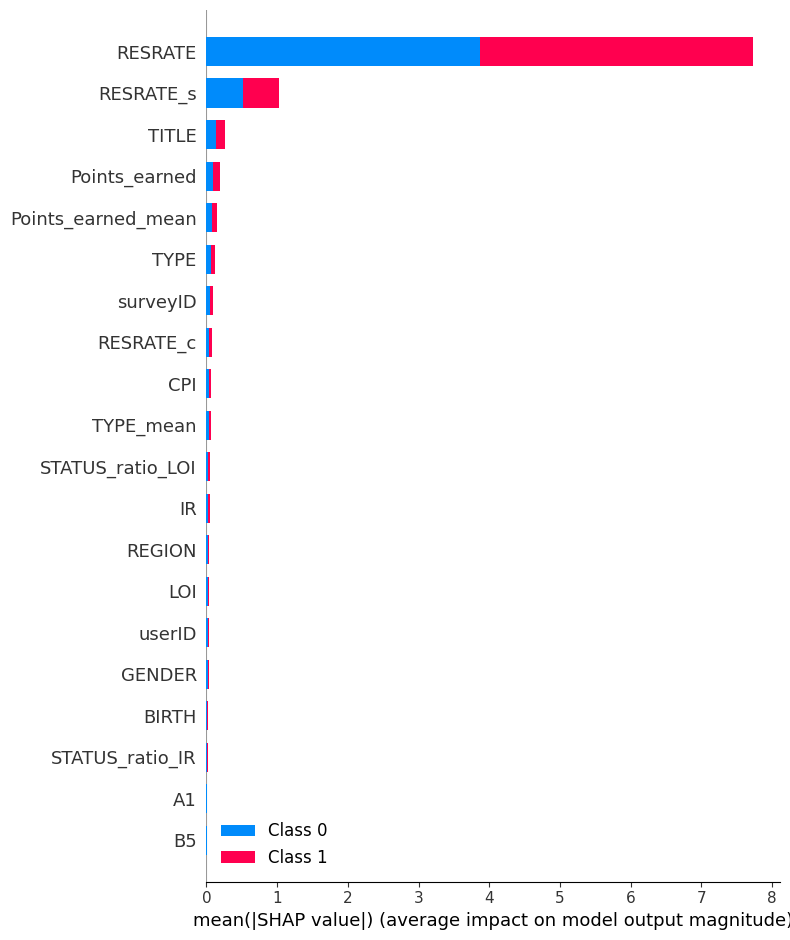

,column_name,shap_importance
21,RESRATE,3.863819
22,RESRATE_s,0.512252
17,TITLE,0.134367
28,Points_earned,0.093577
29,Points_earned_mean,0.074954
5,TYPE,0.059451
1,surveyID,0.048171
23,RESRATE_c,0.038542
20,CPI,0.033925
27,TYPE_mean,0.031521


In [39]:
# FEATURE SELECTION
import shap 
X_importance = X_test

model = LGBMClassifier(random_state=1000).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [40]:
# 지정된(SHAP_THRESHOLD) Shap feature 중요도 이상인 것만 선택
SHAP_THRESHOLD = 0.001  
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]

print(X_train.shape)

(813650, 21)


# optuna 단계시작
- 메일로 설명드린바와 같이 하이퍼파라미터값만 기입을 하여 모델링 하였습니다. 

In [41]:
# X_train_copy=X_train.copy()
# y_train_copy=y_train.copy()

In [42]:
# from sklearn.model_selection import train_test_split  # stratify = y_train 인지 y_train
# X_train_c, X_val, y_train_c, y_val = train_test_split(X_train_copy, y_train_copy, test_size=0.3, stratify = y_train, random_state=42)

In [43]:
# from bayes_opt import BayesianOptimization
# bayesian_params = {
#     'n_estimators': (50, 500),
#     'learning_rate': (0.001, 0.1),
#     'max_depth': (8, 16),
#     'num_leaves': (24, 64),
#     'min_child_samples': (10, 200),
#     'min_child_weight': (1, 50),
#     'subsample': (0.5, 1),
#     'colsample_bytree': (0.5, 1),
#     'max_bin': (10, 500),
#     'reg_lambda': (0.001, 10),
#     'reg_alpha': (0.01, 50)
# }

# def accuracy_eval(n_estimators, learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
#                 colsample_bytree, max_bin, reg_lambda, reg_alpha):
    
#     params = {
#         "n_estimators": int(round(n_estimators)), 
#         'learning_rate': learning_rate,
#         'max_depth': int(round(max_depth)),
#         'num_leaves': int(round(num_leaves)),
#         'min_child_samples': int(round(min_child_samples)),
#         'min_child_weight': int(round(min_child_weight)),
#         'subsample': max(min(subsample, 1), 0),
#         'colsample_bytree': max(min(colsample_bytree, 1), 0),
#         'reg_lambda': max(reg_lambda, 0),
#         'reg_alpha': max(reg_alpha, 0),
#         'random_state': 42,
#         'n_jobs': -1
#     }
    
#     lgb_model = LGBMClassifier(**params)
#     lgb_model.fit(X_train_c, y_train_c, eval_set=[(X_train_c, y_train_c), (X_val, y_val)], eval_metric='auc')
    
#     valid_pred = lgb_model.predict(X_val)
#     accuracy = accuracy_score(y_val, valid_pred)
    
#     return accuracy

In [44]:
# lgbBO = BayesianOptimization(f = accuracy_eval, pbounds=bayesian_params, random_state=1010)
# lgbBO.maximize(init_points=5, n_iter=300) # n_iter 300번 돌림

In [45]:
# # dictionary에 있는 target값을 모두 추출
# target_list = []

# for result in lgbBO.res:
#     target = result['target']
#     target_list.append(target)
# print(target_list)
# # 가장 큰 target 값을 가지는 순번(index)를 추출
# print('maximum target index:', np.argmax(np.array(target_list)))

# # 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
# max_dict = lgbBO.res[np.argmax(np.array(target_list))]
# print(max_dict)

In [46]:
# 위에서 나온 best parameter 값 적용 정수형 값은 반올림함
models_LGBM = LGBMClassifier(
                objective='binary',
                metric='accuracy', 
                n_estimators=445,
                learning_rate=0.1,
                max_bin=136,
                max_depth=16,
                num_leaves=64,
                colsample_bytree=1.0,
                subsample=0.7386359452689183,
                reg_alpha=0.01,
                reg_lambda=10.0,
                min_child_samples=125,
                min_child_weight=1.0,
                silent=-1,
                verbose=-1,
                random_state=42
)


In [47]:
# def objective(trial):
#     model = CatBoostClassifier(
#         iterations=trial.suggest_int("iterations", 100, 1000),
#         learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         depth=trial.suggest_int("depth", 4, 10),
#         l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-2, 100.0),
#         bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
#         random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
#         bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
#         od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
#         od_wait=trial.suggest_int("od_wait", 10, 50),
#         verbose=False,
#         random_state=42
#     )
#     model.fit(X_train_c, y_train_c)
#     y_pred = model.predict(X_val)
#     return accuracy_score(y_val, y_pred)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = optuna.samplers.TPESampler(seed=1)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=50)

# print("Best score:", study.best_value)
# print("Best parameters:", study.best_params)

# Cat_best_params = study.best_params

In [48]:
models_Cat =CatBoostClassifier(iterations=885, 
                       learning_rate=0.08273733773726523, 
                       depth=9, l2_leaf_reg=45.0828306909799, 
                       bootstrap_type='Bayesian', 
                       random_strength=1.1189547899665642e-05, 
                       bagging_temperature=0.06199447009878256, 
                       od_type='Iter', 
                       od_wait=39,
                       random_state=42)                   


In [49]:
# 전처리파일 불러오기
# X_train = pd.read_csv('/kaggle/input/predata/X_train_pre.csv', encoding='cp949')
# X_test = pd.read_csv('/kaggle/input/predata/X_test_pre.csv', encoding='cp949')
X_train = pd.read_csv('X_train_pre.csv', encoding='cp949')
X_test = pd.read_csv('X_test_pre.csv', encoding='cp949')


FileNotFoundError: [Errno 2] No such file or directory: 'X_train_pre.csv'

In [ ]:
# 전처리 데이터에 있는 categorical feature encoding
X_train[cat_features] = le.fit_transform(X_train[cat_features])
X_test[cat_features] = le.transform(X_test[cat_features])

In [ ]:
# train,test데이터에 log를 취함
X_train_logx = np.log(X_train + 1)
X_test_logx = np.log(X_test +1)
X_train_logx.shape

In [ ]:
# log데이터에 대한 feature selection
import shap 

X_importance = X_test_logx

model = LGBMClassifier(random_state=1000,force_row_wise=True).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)


shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)



In [ ]:
# 지정된(SHAP_THRESHOLD) Shap feature 중요도 이상인 것만 선택
SHAP_THRESHOLD = 0.001  
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
X_train_logx = X_train_logx[features_selected]
X_test_logx = X_test_logx[features_selected]

print(X_train_logx.shape)

# optuna 단계시작
- 메일로 설명드린바와 같이 하이퍼파라미터값만 기입을 하여 모델링 하였습니다. 

In [ ]:
# X_train_logx_copy=X_train_logx.copy()
# y_train_copy=y_train.copy()

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(X_train_logx_copy, y_train_copy, test_size=0.3, stratify = y_train, random_state=42)

In [ ]:
# from bayes_opt import BayesianOptimization
# bayesian_params = {
#     'n_estimators': (50, 500),
#     'learning_rate': (0.001, 0.1),
#     'max_depth': (8, 16),
#     'num_leaves': (24, 64),
#     'min_child_samples': (10, 200),
#     'min_child_weight': (1, 50),
#     'subsample': (0.5, 1),
#     'colsample_bytree': (0.5, 1),
#     'max_bin': (10, 500),
#     'reg_lambda': (0.001, 10),
#     'reg_alpha': (0.01, 50)
# }

# def accuracy_eval(n_estimators, learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
#                 colsample_bytree, max_bin, reg_lambda, reg_alpha):
    
#     params = {
#         "n_estimators": int(round(n_estimators)), 
#         'learning_rate': learning_rate,
#         'max_depth': int(round(max_depth)),
#         'num_leaves': int(round(num_leaves)),
#         'min_child_samples': int(round(min_child_samples)),
#         'min_child_weight': int(round(min_child_weight)),
#         'subsample': max(min(subsample, 1), 0),
#         'colsample_bytree': max(min(colsample_bytree, 1), 0),
#         'reg_lambda': max(reg_lambda, 0),
#         'reg_alpha': max(reg_alpha, 0),
#         'random_state': 42,
#         'n_jobs': -1
#     }
    
#     lgb_model = LGBMClassifier(**params)
#     lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='accuracy')
    
#     valid_pred = lgb_model.predict(X_val)
#     accuracy = accuracy_score(y_val, valid_pred)
    
#     return accuracy

In [ ]:
# lgbBO = BayesianOptimization(f = accuracy_eval, pbounds=bayesian_params, random_state=42)
# lgbBO.maximize(init_points=5, n_iter=100)

In [ ]:
# # dictionary에 있는 target값을 모두 추출
# target_list = []

# for result in lgbBO.res:
#     target = result['target']
#     target_list.append(target)
# print(target_list)
# # 가장 큰 target 값을 가지는 순번(index)를 추출
# print('maximum target index:', np.argmax(np.array(target_list)))

# # 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
# max_dict = lgbBO.res[np.argmax(np.array(target_list))]
# print(max_dict)

In [ ]:
log_models_LGBM = LGBMClassifier(
                objective='binary',
                metric='accuracy',  # Fix typo: 'acuuracy' to 'accuracy'
                n_estimators=273,
                learning_rate=0.09356607937896748,
                max_bin=61,
                max_depth=12,
                num_leaves=57,
                colsample_bytree=0.9769221972091021,
                subsample=0.9738345920002343,
                reg_alpha=1.2748564407184528,
                reg_lambda=5.555508132795599,
                min_child_samples=78,
                min_child_weight= 39.95417524785768,
                silent=-1,
                verbose=-1,
                random_state=42
                )

In [ ]:
# model_cat과 같은 파라미터 사용
log_models_Cat = CatBoostClassifier(iterations=885, 
                       learning_rate=0.08273733773726523, 
                       depth=9, l2_leaf_reg=45.0828306909799, 
                       bootstrap_type='Bayesian', 
                       random_strength=1.1189547899665642e-05, 
                       bagging_temperature=0.06199447009878256, 
                       od_type='Iter', 
                       od_wait=39,
                       random_state=42)

In [ ]:
voting = VotingClassifier(
   estimators = [('lgbm', models_LGBM), ('Cat',models_Cat),('log_lgbm',log_models_LGBM),('log_cat',log_models_Cat)], voting='soft')  #(이름,모델) 튜플로                  
voting.fit(X_train, y_train)
voting_predict=voting.predict(X_test)

##### Make a submission

In [ ]:
t = pd.Timestamp.now()
fname = f"voting_submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
pd.DataFrame({'ID': ID_test, 'STATUS': voting_predict}).to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

<font color="#CC3D3D"><p>
# End